In [1]:
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import yfinance as yf
import pandas as pd
import numpy as np
from helpers import Trade
import os

plt.style.use('Solarize_Light2')

# **Loading constants needed**

In [2]:
import json

with open('prams.json', 'r') as file:
    data = json.load(file)

WINDOW, SIGNALS, LOWER_PRICE_DEVIATION, HIGHER_PRICE_DEVIATION, POSITIONS_NATURE, POSITIONS_SHORTCUT, FIGSIZE=data['WINDOW'], data['SIGNALS'], data['LOWER_PRICE_DEVIATION'], data['HIGHER_PRICE_DEVIATION'], data['POSITIONS_NATURE'], data['POSITIONS_SHORTCUT'], data['FIGSIZE']

LOWER_RRR = (LOWER_PRICE_DEVIATION['ENTRY'] - LOWER_PRICE_DEVIATION['TP'])/(LOWER_PRICE_DEVIATION['SL'] - LOWER_PRICE_DEVIATION['ENTRY'])
HIGHER_RRR = (HIGHER_PRICE_DEVIATION['ENTRY'] - HIGHER_PRICE_DEVIATION['TP'])/(HIGHER_PRICE_DEVIATION['SL'] - HIGHER_PRICE_DEVIATION['ENTRY'])

# **1. Loading & Cleaning Data**

In [3]:
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv", index_col=0)
else:
    gold_ticker = yf.Ticker("GC=F")
    # gold_ticker = yf.Ticker("NQ=F")
    df = gold_ticker.history(period="max", interval='1h')
    df.to_csv("data.csv")

df.index = pd.to_datetime(df.index, utc=True)

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)

# display(df.shape)
# display(df.head(3))

# **2. Defining the Strategy (Mean Reversion)**

### We will create Columns needed

In [4]:
df['Mean'] = df['Close'].rolling(window=WINDOW).mean()
# df['Mean'] = df['Close'].ewm(span=WINDOW, adjust=False).mean()
df['STD'] = df['Close'].rolling(window=WINDOW).std()
df['Z-Score'] = np.where(
    df['High'] + df['Low'] > 2 * df['Mean'],
    (df['High'] - df['Mean']) / df['STD'],
    (df['Low'] - df['Mean']) / df['STD']
)

df['Mean'] = df['Mean'].shift(1)
df['STD'] = df['STD'].shift(1)
df['Z-Score'] = df['Z-Score'].shift(1)

df.dropna(inplace=True)

df.head(5)

,Open,High,Low,Close,Mean,STD,Z-Score
Datetime,,,,,,,
2022-10-11 06:00:00+00:00,10927.00,10963.75,10885.50,10892.25,11010.967742,51.537031,-1.828156
2022-10-11 07:00:00+00:00,10891.75,10958.00,10853.25,10909.00,11007.524194,55.756926,-2.188503
2022-10-11 08:00:00+00:00,10908.50,10947.00,10874.75,10889.50,11003.443548,58.216038,-2.579934
2022-10-11 09:00:00+00:00,10889.50,10906.50,10867.75,10883.75,10998.129032,60.882259,-2.026519
2022-10-11 10:00:00+00:00,10883.75,10914.25,10858.50,10913.00,10992.338710,62.981993,-1.978164


### Overview

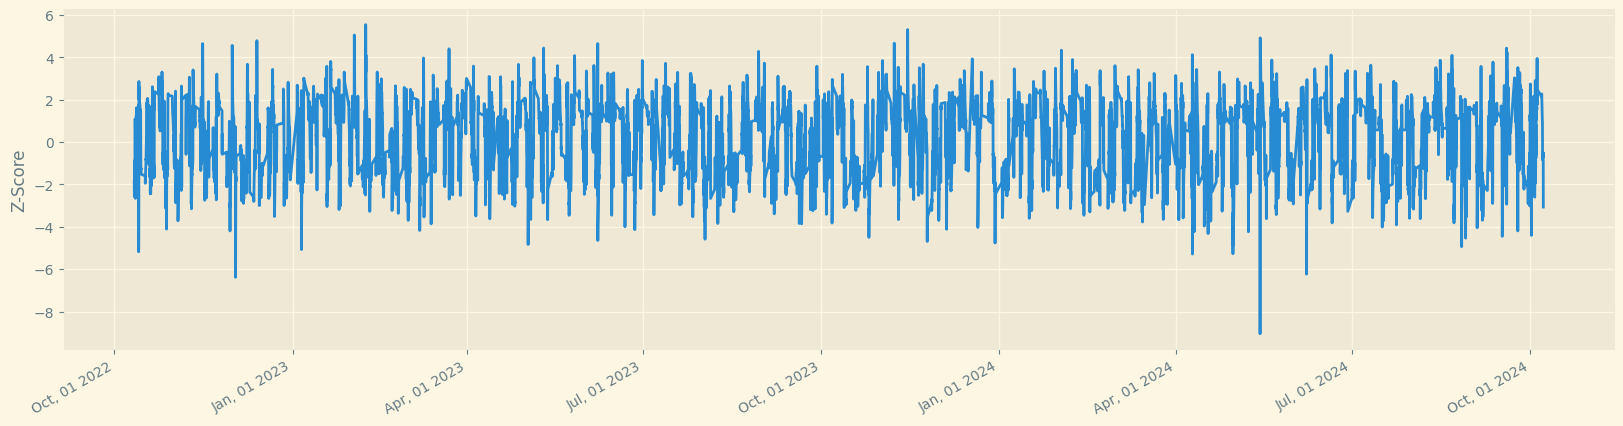

In [5]:
df['Z-Score'].plot(kind='line', xlabel='', ylabel="Z-Score", figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT']))

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

,Z-Score
max,5.544830
min,-9.049532


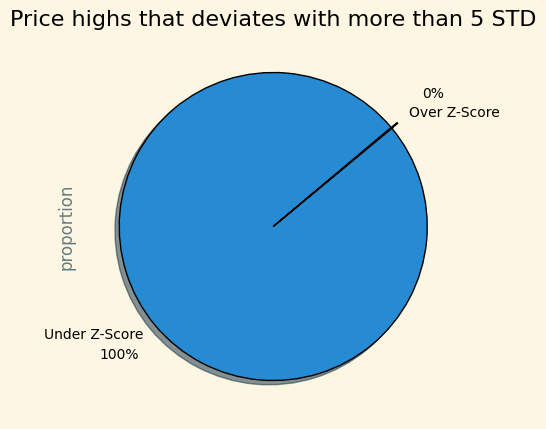

In [6]:
# stats = (abs(df['Z-Score']) > LOWER_PRICE_DEVIATION['ENTRY']).value_counts(normalize=True)
stats = (abs(df['Z-Score']) > HIGHER_PRICE_DEVIATION['ENTRY']).value_counts(normalize=True)

stats.index = ['Under Z-Score', 'Over Z-Score']

stats.plot(
    kind='pie', 
    figsize=(FIGSIZE['LEN'],FIGSIZE['LEN']),
    # title=f"Price lows that deviates with more than {LOWER_PRICE_DEVIATION['ENTRY']} STD",
    title=f"Price highs that deviates with more than {HIGHER_PRICE_DEVIATION['ENTRY']} STD",
    autopct='%1.0f%%',
    pctdistance=1.3,
    labeldistance=1.1,
    shadow=True,
    explode=[0, 0.05],
    wedgeprops={'edgecolor': 'black'},
    startangle=40
    # colors=["#ECDFCC", "#3C3D37"]
)

df['Z-Score'].agg(['max', 'min']).to_frame()

### Generate buy/sell signals

In [7]:
price_deviate_over_xSTD_filter = df['Z-Score'] > HIGHER_PRICE_DEVIATION['ENTRY']
price_deviate_under_xSTD_filter = df['Z-Score'] < -LOWER_PRICE_DEVIATION['ENTRY']

df['Signal'] = 0  # Default to hold/no position
df.loc[price_deviate_under_xSTD_filter, 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[price_deviate_over_xSTD_filter, 'Signal'] = SIGNALS['SELL']  # Sell signal

# [TODO] what if a candel has both signals buy and sell

# **3. Implementing Stop Loss and Take Profit**

In [8]:
df.reset_index(inplace=True)

# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
trade = Trade()

def exit_trade(i: int, is_win: bool):
    df.loc[i, 'Exit_Price'] = trade.tp if is_win else trade.sl
    pnl = (LOWER_RRR if trade.is_buy else HIGHER_RRR) if is_win else -1
    df.loc[i, ['PnL', 'Position']] = [pnl, SIGNALS['BUY' if trade.is_buy else 'SELL']]
    return True

def is_buy_sl(i: int):
    if df.loc[i, 'Low'] <= trade.sl: return exit_trade(i, False)
    return False

def is_buy_tp(i: int, source='High'):
    if df.loc[i, source] > trade.tp: return exit_trade(i, True)
    return False

def is_sell_sl(i: int):
    if df.loc[i, 'High'] >= trade.sl: return exit_trade(i, False)
    return False

def is_sell_tp(i: int, source='Low'):
    if df.loc[i, source] < trade.tp: return exit_trade(i, True)
    return False

# [NB] check SL first then make sure trade is On to check TP

def fill_trade_params(_row, idx):
    trade_signal = _row['Signal']

    is_long = (trade_signal == SIGNALS['BUY'])

    trade.On()
    DEVIATION =  LOWER_PRICE_DEVIATION if is_long else HIGHER_PRICE_DEVIATION
    trade.entry = (_row['Mean'] - trade_signal * DEVIATION['ENTRY'] * _row['STD'])
    trade.tp = (_row['Mean'] - trade_signal * DEVIATION['TP'] * _row['STD'])
    trade.sl = (_row['Mean'] - trade_signal * DEVIATION['SL'] * _row['STD'])
    df.loc[idx, ['Position', 'Entry_Price']] = [trade_signal, trade.entry]

    # check if sl or tp is already hit in the same candel (i)
    if is_long:
        if is_buy_sl(idx): trade.Off()
        elif is_buy_tp(idx, source='Close'): trade.Off()
    else:
        if is_sell_sl(idx): trade.Off()
        elif is_sell_tp(idx, source='Close'): trade.Off()

# Loop through candles and execute trades
for i, row in df.iterrows(): # row for reading, i for writing
    if trade.on: 
        # Track price movement for Stop Loss or Take Profit
        if trade.is_buy: 
            if is_buy_sl(i): trade.Off()
            elif is_buy_tp(i, source='Close'): trade.Off()
        elif trade.is_sell:
            if is_sell_sl(i): trade.Off()
            elif is_sell_tp(i, source='Close'): trade.Off()
    else:
        if row['Signal'] != 0: # Check if there's a signal
            fill_trade_params(row, i)

# **4. Backtesting & Overview**

In [9]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
PnL = trades['PnL'].value_counts(normalize=True)
win_rate = 0

if not PnL.empty:
    win_rate = PnL[PnL.index > 0].iloc[0]

expectency = (LOWER_RRR + 1) * win_rate - 1

strategy_stats_df = pd.DataFrame(
    np.array([[
        total_trades,
        total_pnl,
        round(win_rate * 100, 2),
        LOWER_RRR,
        expectency,
        expectency * total_trades
    ]]),
    columns=['Total Trades', 'Total Profit/Loss (RR)', 'Win rate (%)', 'Risk-Reward Ratio', 'Expectancy', 'Expected return'],
    index=['Metrics']
)

strategy_stats_df

,Total Trades,Total Profit/Loss (RR),Win rate (%),Risk-Reward Ratio,Expectancy,Expected return
Metrics,7.0,9.0,57.14,3.0,1.285714,9.0


- Save results

In [10]:
# strategy_stats_df.to_csv("results.csv")

- **PnL**

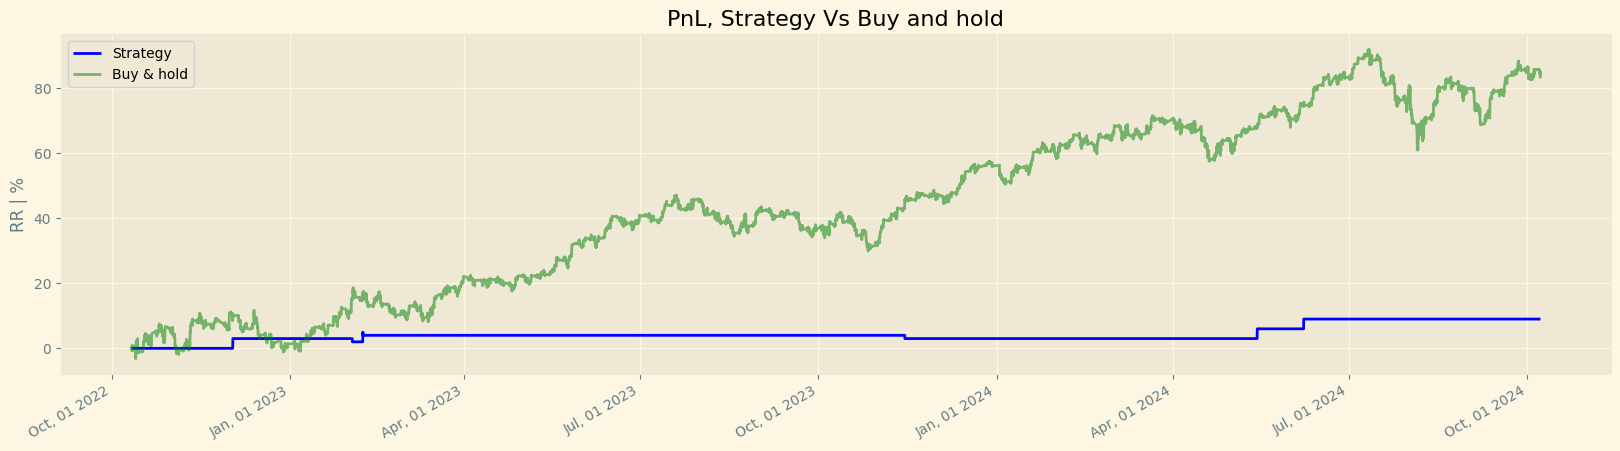

In [11]:
df.set_index('Datetime', inplace=True)

starting_inv_price = df['Close'].iloc[0]

# Plot the Strategy returns
df['Cumulative_PnL'].plot(
        label='Strategy', 
        figsize=(FIGSIZE['WIDTH'], 
        FIGSIZE['HEIGHT']), 
        color='blue', 
        xlabel='',
        ylabel='RR | %'
    )

(100 * (df['Close'] - starting_inv_price)/starting_inv_price).plot(
        label='Buy & hold', 
        figsize=(FIGSIZE['WIDTH'], 
        FIGSIZE['HEIGHT']), 
        color='green', 
        xlabel='',
        alpha=.5,
        ylabel='RR | %'
    )

plt.title('PnL, Strategy Vs Buy and hold')
plt.legend()

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

- **PnL-Drawdown** (not from Equity)

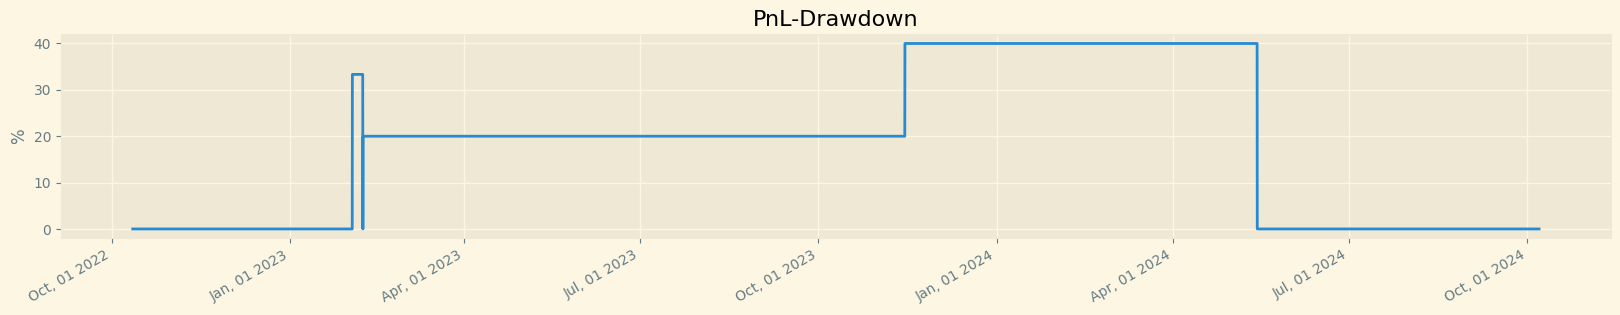

In [12]:
df['Peak'] = df['Cumulative_PnL'].cummax()

# df['Drawdown'] = (df['Peak'] - df['Cumulative_PnL']) / abs(df['Peak'])
df['Drawdown'] = np.where(df['Peak'] == 0, abs(df['Cumulative_PnL']), (df['Peak'] - df['Cumulative_PnL']) / df['Peak'])

# df['Drawdown'] = df.apply(lambda row: ((row['Peak'] - row['Cumulative_PnL']) / row['Peak']) if row['Peak'] != 0 else 0, axis=1)
# df['Drawdown'] = np.where(df['Peak'] != 0, (df['Peak'] - df['Cumulative_PnL']) / df['Peak'], 0)

(df['Drawdown'] * 100).plot(
    kind='line', 
    figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] - 2),
    title="PnL-Drawdown",
    ylabel="%",
    xlabel=''
)

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

In [13]:
print(f"Max PnL-drawdown is {round(100 * df['Drawdown'].max(), 2)} %")

Max PnL-drawdown is 40.0 %


# **5. Overview on positions**

Text(0.5, 1.0, 'Positions nature')

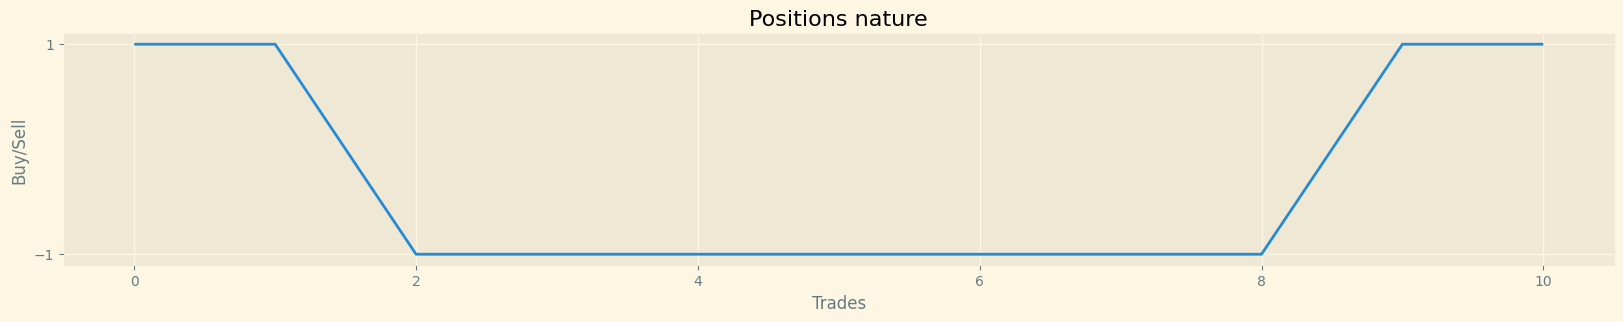

In [14]:
positions = df.loc[df['Position'] != 0, 'Position'].values 

pd.Series(positions).plot(
    figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] - 2), 
    yticks=[-1, 1],
    ylabel='Buy/Sell',
    xlabel='Trades'
)

plt.title('Positions nature')

<Axes: title={'center': 'Positions nature distribution'}, ylabel='proportion'>

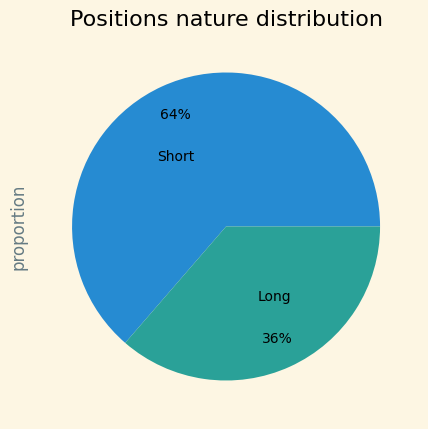

In [15]:
positions_nature_distribution_df = df.loc[df['Position'] != 0, 'Position'].value_counts(normalize=True)

positions_nature_distribution_df.index = [POSITIONS_NATURE[str(x)] for x in positions_nature_distribution_df.index.to_list()]

positions_nature_distribution_df

positions_nature_distribution_df.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Positions nature distribution",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

# [TODO] probability distribution

<Axes: title={'center': 'Percentage of Long & Short from losing positions'}, ylabel='proportion'>

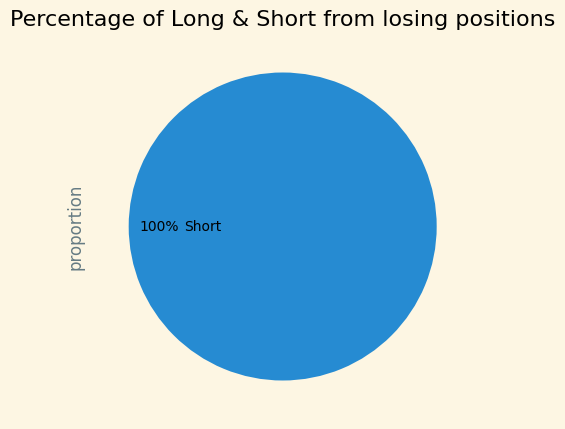

In [16]:
losing_positions_sr = df.loc[df['PnL'] == -1, 'Position'].value_counts(normalize=True)

losing_positions_sr.index = [POSITIONS_NATURE[str(x)] for x in losing_positions_sr.index.to_list()]

losing_positions_sr.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Percentage of Long & Short from losing positions",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.4
)

In [17]:
# [TODO] max consecutive wins & losses (so we can avoid drawdown)

# **6. A study on Drawdown**